# Deep Learning: Endoscopy segmentation.
[Dataset](https://www.kaggle.com/datasets/newslab/cholecseg8k?resource=download)

In [1]:
import os

os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"

In [2]:
import torch
from glob import glob
import numpy as np
import time
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import cv2
import random
from pytorch_Uformer import modelPool
from pytorch_Uformer import losses
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [3]:
torch.cuda.is_available(), torch.cuda.get_device_name(0)

(True, 'NVIDIA GeForce RTX 2060 SUPER')

In [4]:
SEED = 33
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.use_deterministic_algorithms(True)

In [5]:
CLASS_WEIGHTS = np.array([2.45780159e-01, 2.24610010e-01, 2.24005501e-01, 1.87119512e-02,
 1.46965911e-01, 2.54698498e-02, 2.35562466e-02, 4.28713053e-03,
 3.93593665e-04, 1.38500705e-02, 6.78984614e-02, 1.01436955e-04,
 4.36967906e-03])

In [6]:
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

NUM_CLASSES = 13
# initialize learning rate, number of epochs to train for, and the
# batch size
INIT_LR = 0.0001
NUM_EPOCHS = 100
BATCH_SIZE = 32
# define the input image dimensions
INPUT_IMAGE_WIDTH = 64
INPUT_IMAGE_HEIGHT = 64

## Data preparation.

In [7]:
IMAGE_DATASET_PATH = glob(f'../*/*/*/frame_*_endo.png')
MASK_DATASET_PATH  = glob(f'../*/*/*/frame_*_endo_watershed_mask.png')
N = len(IMAGE_DATASET_PATH)
assert len(IMAGE_DATASET_PATH) == len(MASK_DATASET_PATH)

print(f'Number of samples: {str(len(MASK_DATASET_PATH))}')

Number of samples: 8080


In [8]:
def to_categorical(y, num_classes=None, dtype="float32"):
	y = np.array(y, dtype="int")
	input_shape = y.shape

	# Shrink the last dimension if the shape is (..., 1).
	if input_shape and input_shape[-1] == 1 and len(input_shape) > 1:
		input_shape = tuple(input_shape[:-1])

	y = y.reshape(-1)
	if not num_classes:
		num_classes = np.max(y) + 1
	n = y.shape[0]
	categorical = np.zeros((n, num_classes), dtype=dtype)
	categorical[np.arange(n), y] = 1
	output_shape = input_shape + (num_classes,)
	categorical = np.reshape(categorical, output_shape)
	return categorical

labels = [[11],[21],[13],[12],[31],[23],[24],[25],[32],[22],[33],[5]]
def encode_mask(masks_arr, n_classes=NUM_CLASSES, H=INPUT_IMAGE_HEIGHT, W=INPUT_IMAGE_WIDTH, labels_arr=labels):
    y_encoded = np.zeros((H, W, 1), dtype=np.uint8)

    for i, label in enumerate(labels_arr):
        y_encoded[np.all(label == masks_arr, axis=-1)] = i + 1
    
    return to_categorical(y_encoded, num_classes=n_classes)

class SegmentationDataset(Dataset):
	def __init__(self, imagePaths, maskPaths):
		# store the image and mask filepaths, and augmentation
		# transforms
		self.imagePaths = imagePaths
		self.maskPaths = maskPaths

	def __len__(self):
		# return the number of total samples contained in the dataset
		return len(self.imagePaths)
	
	def __getitem__(self, idx):
		# grab the image path from the current index
		imagePath = self.imagePaths[idx]
		# load the image from disk, swap its channels from BGR to RGB,
		# and read the associated mask from disk in grayscale mode
		image = cv2.imread(imagePath)
		image = image[10:-10, 10:-10,:]
		image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
		image = image / 255
		image = torch.from_numpy(np.float32(image))
		image = image.permute(2,0,1)

		mask = cv2.imread(self.maskPaths[idx])
		mask = mask[10:-10, 10:-10,:]
		mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
		mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
		mask = np.expand_dims(mask, axis=-1)
		mask = encode_mask(mask)
		mask = torch.from_numpy(np.float32(mask))
		mask = mask.permute(2,0,1)

		assert image.shape == (3, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad image shape {image.shape}"
		assert mask.shape == (13, INPUT_IMAGE_HEIGHT, INPUT_IMAGE_WIDTH), f"Bad mask shape {mask.shape}"

		# return a tuple of the image and its mask
		return image, mask

In [9]:
uformer = modelPool.Uformer(img_size=INPUT_IMAGE_HEIGHT,in_chans=13, embed_dim=16, win_size=8, token_projection='linear', token_mlp='leff',modulator=True)
trainImages, testImages, trainMasks, testMasks = train_test_split(IMAGE_DATASET_PATH, MASK_DATASET_PATH, test_size=0.2, random_state=43)

In [10]:
# define transformations
from torch.utils.data import DataLoader

# create the train and test datasets
trainDS = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks)
testDS = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks)
print(f"[INFO] found {len(trainDS)} examples in the training set...")
print(f"[INFO] found {len(testDS)} examples in the test set...")
# create the training and test data loaders
num_workers = 4
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

trainLoader = DataLoader(
	trainDS, 
	shuffle=True,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)
testLoader = DataLoader(
	testDS, shuffle=False,
	batch_size=BATCH_SIZE, 
	pin_memory=PIN_MEMORY,
    worker_init_fn=seed_worker,
    generator=g
)

[INFO] found 6464 examples in the training set...
[INFO] found 1616 examples in the test set...


In [11]:
uformer = uformer.to(DEVICE)
softmax = torch.nn.Softmax(1)
# initialize loss function and optimizer
lossFunc = losses.DiceLoss(class_weights=CLASS_WEIGHTS).cuda()
opt = torch.optim.Adam(uformer.parameters(), lr=INIT_LR, betas=(0.9, 0.999),eps=1e-8, weight_decay=1e-5)
iouMetric = losses.MeanIoU().cuda()
gdlMetric = losses.DiceCoeficient().cuda()
# calculate steps per epoch for training and test set
trainSteps = len(trainDS) // BATCH_SIZE
testSteps = len(testDS) // BATCH_SIZE
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": [], "train_IoU": [], "test_IoU": [],"train_DC": [], "test_DC": []}

In [12]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
for e in range(NUM_EPOCHS):
	torch.cuda.empty_cache()
	# set the model in training mode
	uformer.train()
	# initialize the total training and validation loss
	totalTrainLoss = 0
	totalTestLoss = 0

	totalTrainIoU = 0
	totalTestIoU = 0
	totalTrainDC = 0
	totalTestDC = 0
	# loop over the training set
	for i, (x, y) in enumerate(tqdm(trainLoader)):
		# send the input to the device
		x, y = x.to(DEVICE), y.to(DEVICE)
		# perform a forward pass and calculate the training loss
		pred = uformer(x)
		assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
		pred = softmax(pred)
		loss = lossFunc(pred, y)
		# first, zero out any previously accumulated gradients, then
		# perform backpropagation, and then update model parameters
		opt.zero_grad()
		loss.backward()
		opt.step()
		# add the loss to the total training loss so far
		totalTrainLoss += loss
		totalTrainIoU += iouMetric(pred, y)
		totalTrainDC += gdlMetric(pred, y)
	# switch off autograd
	with torch.no_grad():
		# set the model in evaluation mode
		uformer.eval()
		# loop over the validation set
		for (x, y) in testLoader:
			# send the input to the device
			(x, y) = (x.to(DEVICE), y.to(DEVICE))
			# make the predictions and calculate the validation loss
			pred = uformer(x)
			assert pred.shape == y.shape, f"{pred.shape} != {y.shape}" # B, C, H, W
			pred = softmax(pred)
			totalTestLoss += lossFunc(pred, y)
			totalTestIoU += iouMetric(pred, y)
			totalTestDC += gdlMetric(pred, y)
			
	# calculate the average training and validation loss
	avgTrainLoss = totalTrainLoss / trainSteps
	avgTestLoss = totalTestLoss / testSteps

	avgTrainIoU = totalTrainIoU / trainSteps
	avgTestIoU = totalTestIoU / testSteps
	avgTrainDC = totalTrainDC / trainSteps
	avgTestDC = totalTestDC / testSteps
	# update our training history
	H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
	H["test_loss"].append(avgTestLoss.cpu().detach().numpy())

	H["train_IoU"].append(avgTrainIoU.cpu().detach().numpy())
	H["test_IoU"].append(avgTestIoU.cpu().detach().numpy())
	H["train_DC"].append(avgTrainDC.cpu().detach().numpy())
	H["test_DC"].append(avgTestDC.cpu().detach().numpy())

	# print the model training and validation information
	print("[INFO] EPOCH: {}/{}".format(e + 1, NUM_EPOCHS))
	print(f"Train loss: {avgTrainLoss:.6f}, Test loss: {avgTestLoss:.4f}, " + 
       f"Train IoU: {avgTrainIoU:.4f}, Test IoU: {avgTestIoU:.4f}, Train Dice: {avgTrainDC:.4f}, Test Dice: {avgTestDC:.4f}")

# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


100%|██████████| 202/202 [03:22<00:00,  1.00s/it]


[INFO] EPOCH: 1/100
Train loss: 0.956074, Test loss: 0.9648, Train IoU: 0.4340, Test IoU: 0.5885, Train Dice: 0.5877, Test Dice: 0.7460


100%|██████████| 202/202 [01:51<00:00,  1.81it/s]


[INFO] EPOCH: 2/100
Train loss: 0.943241, Test loss: 0.9590, Train IoU: 0.6184, Test IoU: 0.6822, Train Dice: 0.7632, Test Dice: 0.8173


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 3/100
Train loss: 0.939648, Test loss: 0.9560, Train IoU: 0.6762, Test IoU: 0.7342, Train Dice: 0.8062, Test Dice: 0.8536


100%|██████████| 202/202 [01:50<00:00,  1.84it/s]


[INFO] EPOCH: 4/100
Train loss: 0.937711, Test loss: 0.9551, Train IoU: 0.7051, Test IoU: 0.7452, Train Dice: 0.8265, Test Dice: 0.8610


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 5/100
Train loss: 0.936331, Test loss: 0.9541, Train IoU: 0.7287, Test IoU: 0.7654, Train Dice: 0.8425, Test Dice: 0.8744


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 6/100
Train loss: 0.935300, Test loss: 0.9529, Train IoU: 0.7468, Test IoU: 0.7839, Train Dice: 0.8546, Test Dice: 0.8864


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 7/100
Train loss: 0.934523, Test loss: 0.9522, Train IoU: 0.7609, Test IoU: 0.7964, Train Dice: 0.8638, Test Dice: 0.8943


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 8/100
Train loss: 0.933956, Test loss: 0.9519, Train IoU: 0.7706, Test IoU: 0.8037, Train Dice: 0.8700, Test Dice: 0.8989


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 9/100
Train loss: 0.933557, Test loss: 0.9514, Train IoU: 0.7779, Test IoU: 0.8107, Train Dice: 0.8747, Test Dice: 0.9033


100%|██████████| 202/202 [01:52<00:00,  1.80it/s]


[INFO] EPOCH: 10/100
Train loss: 0.933051, Test loss: 0.9510, Train IoU: 0.7869, Test IoU: 0.8176, Train Dice: 0.8803, Test Dice: 0.9075


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 11/100
Train loss: 0.932647, Test loss: 0.9505, Train IoU: 0.7929, Test IoU: 0.8248, Train Dice: 0.8842, Test Dice: 0.9120


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 12/100
Train loss: 0.932280, Test loss: 0.9503, Train IoU: 0.7996, Test IoU: 0.8298, Train Dice: 0.8884, Test Dice: 0.9150


100%|██████████| 202/202 [01:50<00:00,  1.84it/s]


[INFO] EPOCH: 13/100
Train loss: 0.931896, Test loss: 0.9500, Train IoU: 0.8069, Test IoU: 0.8351, Train Dice: 0.8928, Test Dice: 0.9182


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 14/100
Train loss: 0.931391, Test loss: 0.9495, Train IoU: 0.8160, Test IoU: 0.8444, Train Dice: 0.8984, Test Dice: 0.9239


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 15/100
Train loss: 0.930984, Test loss: 0.9491, Train IoU: 0.8234, Test IoU: 0.8511, Train Dice: 0.9029, Test Dice: 0.9279


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 16/100
Train loss: 0.930727, Test loss: 0.9490, Train IoU: 0.8288, Test IoU: 0.8551, Train Dice: 0.9061, Test Dice: 0.9303


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 17/100
Train loss: 0.930538, Test loss: 0.9488, Train IoU: 0.8331, Test IoU: 0.8568, Train Dice: 0.9087, Test Dice: 0.9312


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 18/100
Train loss: 0.930345, Test loss: 0.9485, Train IoU: 0.8370, Test IoU: 0.8632, Train Dice: 0.9111, Test Dice: 0.9350


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 19/100
Train loss: 0.930201, Test loss: 0.9485, Train IoU: 0.8400, Test IoU: 0.8645, Train Dice: 0.9128, Test Dice: 0.9358


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 20/100
Train loss: 0.929963, Test loss: 0.9483, Train IoU: 0.8448, Test IoU: 0.8681, Train Dice: 0.9157, Test Dice: 0.9379


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 21/100
Train loss: 0.929969, Test loss: 0.9484, Train IoU: 0.8445, Test IoU: 0.8660, Train Dice: 0.9155, Test Dice: 0.9367


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 22/100
Train loss: 0.929688, Test loss: 0.9479, Train IoU: 0.8495, Test IoU: 0.8743, Train Dice: 0.9184, Test Dice: 0.9415


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 23/100
Train loss: 0.929539, Test loss: 0.9477, Train IoU: 0.8532, Test IoU: 0.8788, Train Dice: 0.9206, Test Dice: 0.9441


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 24/100
Train loss: 0.929391, Test loss: 0.9477, Train IoU: 0.8560, Test IoU: 0.8797, Train Dice: 0.9222, Test Dice: 0.9446


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 25/100
Train loss: 0.929263, Test loss: 0.9476, Train IoU: 0.8584, Test IoU: 0.8819, Train Dice: 0.9236, Test Dice: 0.9459


100%|██████████| 202/202 [01:48<00:00,  1.85it/s]


[INFO] EPOCH: 26/100
Train loss: 0.929177, Test loss: 0.9475, Train IoU: 0.8603, Test IoU: 0.8829, Train Dice: 0.9247, Test Dice: 0.9465


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 27/100
Train loss: 0.929069, Test loss: 0.9474, Train IoU: 0.8627, Test IoU: 0.8869, Train Dice: 0.9261, Test Dice: 0.9487


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 28/100
Train loss: 0.928908, Test loss: 0.9473, Train IoU: 0.8660, Test IoU: 0.8878, Train Dice: 0.9280, Test Dice: 0.9493


100%|██████████| 202/202 [01:48<00:00,  1.85it/s]


[INFO] EPOCH: 29/100
Train loss: 0.928835, Test loss: 0.9472, Train IoU: 0.8674, Test IoU: 0.8909, Train Dice: 0.9289, Test Dice: 0.9510


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 30/100
Train loss: 0.928754, Test loss: 0.9472, Train IoU: 0.8692, Test IoU: 0.8898, Train Dice: 0.9299, Test Dice: 0.9504


100%|██████████| 202/202 [01:50<00:00,  1.83it/s]


[INFO] EPOCH: 31/100
Train loss: 0.928632, Test loss: 0.9470, Train IoU: 0.8718, Test IoU: 0.8922, Train Dice: 0.9314, Test Dice: 0.9518


100%|██████████| 202/202 [01:50<00:00,  1.82it/s]


[INFO] EPOCH: 32/100
Train loss: 0.928560, Test loss: 0.9470, Train IoU: 0.8732, Test IoU: 0.8935, Train Dice: 0.9321, Test Dice: 0.9525


100%|██████████| 202/202 [01:49<00:00,  1.85it/s]


[INFO] EPOCH: 33/100
Train loss: 0.928500, Test loss: 0.9469, Train IoU: 0.8748, Test IoU: 0.8968, Train Dice: 0.9330, Test Dice: 0.9544


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 34/100
Train loss: 0.928467, Test loss: 0.9468, Train IoU: 0.8752, Test IoU: 0.8970, Train Dice: 0.9333, Test Dice: 0.9545


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 35/100
Train loss: 0.928903, Test loss: 0.9488, Train IoU: 0.8652, Test IoU: 0.8530, Train Dice: 0.9274, Test Dice: 0.9290


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 36/100
Train loss: 0.928836, Test loss: 0.9470, Train IoU: 0.8672, Test IoU: 0.8943, Train Dice: 0.9287, Test Dice: 0.9530


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 37/100
Train loss: 0.928660, Test loss: 0.9470, Train IoU: 0.8704, Test IoU: 0.8942, Train Dice: 0.9306, Test Dice: 0.9529


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 38/100
Train loss: 0.928327, Test loss: 0.9468, Train IoU: 0.8781, Test IoU: 0.8966, Train Dice: 0.9350, Test Dice: 0.9543


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 39/100
Train loss: 0.928222, Test loss: 0.9465, Train IoU: 0.8805, Test IoU: 0.9039, Train Dice: 0.9364, Test Dice: 0.9584


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 40/100
Train loss: 0.929237, Test loss: 0.9469, Train IoU: 0.8588, Test IoU: 0.8957, Train Dice: 0.9236, Test Dice: 0.9538


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 41/100
Train loss: 0.928633, Test loss: 0.9467, Train IoU: 0.8706, Test IoU: 0.8998, Train Dice: 0.9307, Test Dice: 0.9561


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 42/100
Train loss: 0.928193, Test loss: 0.9470, Train IoU: 0.8804, Test IoU: 0.8918, Train Dice: 0.9363, Test Dice: 0.9515


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 43/100
Train loss: 0.928478, Test loss: 0.9467, Train IoU: 0.8735, Test IoU: 0.8985, Train Dice: 0.9323, Test Dice: 0.9553


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 44/100
Train loss: 0.928306, Test loss: 0.9473, Train IoU: 0.8773, Test IoU: 0.8855, Train Dice: 0.9345, Test Dice: 0.9480


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 45/100
Train loss: 0.928081, Test loss: 0.9464, Train IoU: 0.8817, Test IoU: 0.9049, Train Dice: 0.9371, Test Dice: 0.9590


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 46/100
Train loss: 0.928707, Test loss: 0.9469, Train IoU: 0.8675, Test IoU: 0.8932, Train Dice: 0.9289, Test Dice: 0.9523


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 47/100
Train loss: 0.928672, Test loss: 0.9472, Train IoU: 0.8682, Test IoU: 0.8871, Train Dice: 0.9293, Test Dice: 0.9489


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 48/100
Train loss: 0.929574, Test loss: 0.9471, Train IoU: 0.8493, Test IoU: 0.8904, Train Dice: 0.9178, Test Dice: 0.9508


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 49/100
Train loss: 0.929615, Test loss: 0.9470, Train IoU: 0.8493, Test IoU: 0.8933, Train Dice: 0.9180, Test Dice: 0.9524


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 50/100
Train loss: 0.928211, Test loss: 0.9467, Train IoU: 0.8794, Test IoU: 0.9002, Train Dice: 0.9358, Test Dice: 0.9563


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 51/100
Train loss: 0.927990, Test loss: 0.9465, Train IoU: 0.8841, Test IoU: 0.9051, Train Dice: 0.9384, Test Dice: 0.9591


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 52/100
Train loss: 0.928991, Test loss: 0.9467, Train IoU: 0.8614, Test IoU: 0.8995, Train Dice: 0.9253, Test Dice: 0.9559


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 53/100
Train loss: 0.928498, Test loss: 0.9466, Train IoU: 0.8723, Test IoU: 0.9004, Train Dice: 0.9316, Test Dice: 0.9565


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 54/100
Train loss: 0.927988, Test loss: 0.9464, Train IoU: 0.8845, Test IoU: 0.9044, Train Dice: 0.9386, Test Dice: 0.9587


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 55/100
Train loss: 0.927845, Test loss: 0.9464, Train IoU: 0.8872, Test IoU: 0.9055, Train Dice: 0.9402, Test Dice: 0.9593


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 56/100
Train loss: 0.927757, Test loss: 0.9462, Train IoU: 0.8889, Test IoU: 0.9105, Train Dice: 0.9411, Test Dice: 0.9621


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 57/100
Train loss: 0.927800, Test loss: 0.9463, Train IoU: 0.8877, Test IoU: 0.9065, Train Dice: 0.9404, Test Dice: 0.9598


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 58/100
Train loss: 0.928012, Test loss: 0.9470, Train IoU: 0.8828, Test IoU: 0.8917, Train Dice: 0.9376, Test Dice: 0.9515


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 59/100
Train loss: 0.928038, Test loss: 0.9466, Train IoU: 0.8823, Test IoU: 0.9029, Train Dice: 0.9374, Test Dice: 0.9578


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 60/100
Train loss: 0.928700, Test loss: 0.9485, Train IoU: 0.8683, Test IoU: 0.8591, Train Dice: 0.9292, Test Dice: 0.9326


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 61/100
Train loss: 0.929004, Test loss: 0.9470, Train IoU: 0.8604, Test IoU: 0.8910, Train Dice: 0.9247, Test Dice: 0.9511


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 62/100
Train loss: 0.928230, Test loss: 0.9490, Train IoU: 0.8774, Test IoU: 0.8484, Train Dice: 0.9345, Test Dice: 0.9263


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 63/100
Train loss: 0.928575, Test loss: 0.9471, Train IoU: 0.8706, Test IoU: 0.8894, Train Dice: 0.9307, Test Dice: 0.9502


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 64/100
Train loss: 0.927902, Test loss: 0.9463, Train IoU: 0.8852, Test IoU: 0.9064, Train Dice: 0.9391, Test Dice: 0.9598


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 65/100
Train loss: 0.927690, Test loss: 0.9465, Train IoU: 0.8899, Test IoU: 0.9024, Train Dice: 0.9417, Test Dice: 0.9575


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 66/100
Train loss: 0.927732, Test loss: 0.9464, Train IoU: 0.8888, Test IoU: 0.9065, Train Dice: 0.9410, Test Dice: 0.9599


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 67/100
Train loss: 0.927969, Test loss: 0.9473, Train IoU: 0.8841, Test IoU: 0.8849, Train Dice: 0.9383, Test Dice: 0.9476


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 68/100
Train loss: 0.928342, Test loss: 0.9469, Train IoU: 0.8757, Test IoU: 0.8929, Train Dice: 0.9336, Test Dice: 0.9522


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 69/100
Train loss: 0.927767, Test loss: 0.9462, Train IoU: 0.8878, Test IoU: 0.9102, Train Dice: 0.9405, Test Dice: 0.9620


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 70/100
Train loss: 0.929305, Test loss: 0.9479, Train IoU: 0.8556, Test IoU: 0.8731, Train Dice: 0.9213, Test Dice: 0.9408


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 71/100
Train loss: 0.928419, Test loss: 0.9467, Train IoU: 0.8725, Test IoU: 0.8982, Train Dice: 0.9318, Test Dice: 0.9552


100%|██████████| 202/202 [01:48<00:00,  1.87it/s]


[INFO] EPOCH: 72/100
Train loss: 0.928003, Test loss: 0.9465, Train IoU: 0.8823, Test IoU: 0.9025, Train Dice: 0.9374, Test Dice: 0.9576


100%|██████████| 202/202 [01:49<00:00,  1.84it/s]


[INFO] EPOCH: 73/100
Train loss: 0.928120, Test loss: 0.9500, Train IoU: 0.8803, Test IoU: 0.8285, Train Dice: 0.9360, Test Dice: 0.9142


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 74/100
Train loss: 0.928734, Test loss: 0.9468, Train IoU: 0.8668, Test IoU: 0.8962, Train Dice: 0.9285, Test Dice: 0.9540


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 75/100
Train loss: 0.928007, Test loss: 0.9471, Train IoU: 0.8817, Test IoU: 0.8892, Train Dice: 0.9370, Test Dice: 0.9501


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 76/100
Train loss: 0.928022, Test loss: 0.9464, Train IoU: 0.8812, Test IoU: 0.9048, Train Dice: 0.9368, Test Dice: 0.9589


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 77/100
Train loss: 0.927558, Test loss: 0.9461, Train IoU: 0.8915, Test IoU: 0.9101, Train Dice: 0.9426, Test Dice: 0.9619


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 78/100
Train loss: 0.927634, Test loss: 0.9462, Train IoU: 0.8902, Test IoU: 0.9089, Train Dice: 0.9418, Test Dice: 0.9612


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 79/100
Train loss: 0.927387, Test loss: 0.9460, Train IoU: 0.8958, Test IoU: 0.9134, Train Dice: 0.9450, Test Dice: 0.9637


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 80/100
Train loss: 0.927375, Test loss: 0.9460, Train IoU: 0.8962, Test IoU: 0.9137, Train Dice: 0.9452, Test Dice: 0.9639


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 81/100
Train loss: 0.928052, Test loss: 0.9466, Train IoU: 0.8814, Test IoU: 0.9015, Train Dice: 0.9367, Test Dice: 0.9571


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 82/100
Train loss: 0.927595, Test loss: 0.9461, Train IoU: 0.8915, Test IoU: 0.9108, Train Dice: 0.9426, Test Dice: 0.9623


100%|██████████| 202/202 [01:48<00:00,  1.86it/s]


[INFO] EPOCH: 83/100
Train loss: 0.927746, Test loss: 0.9461, Train IoU: 0.8877, Test IoU: 0.9098, Train Dice: 0.9404, Test Dice: 0.9617


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 84/100
Train loss: 0.927395, Test loss: 0.9460, Train IoU: 0.8959, Test IoU: 0.9131, Train Dice: 0.9450, Test Dice: 0.9636


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 85/100
Train loss: 0.927276, Test loss: 0.9459, Train IoU: 0.8986, Test IoU: 0.9163, Train Dice: 0.9466, Test Dice: 0.9653


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 86/100
Train loss: 0.927282, Test loss: 0.9458, Train IoU: 0.8983, Test IoU: 0.9177, Train Dice: 0.9464, Test Dice: 0.9661


100%|██████████| 202/202 [01:46<00:00,  1.90it/s]


[INFO] EPOCH: 87/100
Train loss: 0.927258, Test loss: 0.9460, Train IoU: 0.8997, Test IoU: 0.9160, Train Dice: 0.9471, Test Dice: 0.9652


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 88/100
Train loss: 0.927454, Test loss: 0.9459, Train IoU: 0.8948, Test IoU: 0.9166, Train Dice: 0.9444, Test Dice: 0.9655


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 89/100
Train loss: 0.927513, Test loss: 0.9460, Train IoU: 0.8934, Test IoU: 0.9140, Train Dice: 0.9436, Test Dice: 0.9640


100%|██████████| 202/202 [01:47<00:00,  1.89it/s]


[INFO] EPOCH: 90/100
Train loss: 0.927356, Test loss: 0.9460, Train IoU: 0.8964, Test IoU: 0.9125, Train Dice: 0.9453, Test Dice: 0.9632


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 91/100
Train loss: 0.927177, Test loss: 0.9458, Train IoU: 0.9010, Test IoU: 0.9188, Train Dice: 0.9479, Test Dice: 0.9667


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 92/100
Train loss: 0.930366, Test loss: 0.9479, Train IoU: 0.8343, Test IoU: 0.8724, Train Dice: 0.9089, Test Dice: 0.9404


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 93/100
Train loss: 0.930277, Test loss: 0.9472, Train IoU: 0.8358, Test IoU: 0.8868, Train Dice: 0.9093, Test Dice: 0.9487


100%|██████████| 202/202 [01:47<00:00,  1.87it/s]


[INFO] EPOCH: 94/100
Train loss: 0.929552, Test loss: 0.9477, Train IoU: 0.8497, Test IoU: 0.8773, Train Dice: 0.9183, Test Dice: 0.9432


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 95/100
Train loss: 0.928502, Test loss: 0.9468, Train IoU: 0.8717, Test IoU: 0.8962, Train Dice: 0.9314, Test Dice: 0.9541


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 96/100
Train loss: 0.927849, Test loss: 0.9463, Train IoU: 0.8853, Test IoU: 0.9058, Train Dice: 0.9391, Test Dice: 0.9595


100%|██████████| 202/202 [01:46<00:00,  1.89it/s]


[INFO] EPOCH: 97/100
Train loss: 0.928372, Test loss: 0.9465, Train IoU: 0.8739, Test IoU: 0.9027, Train Dice: 0.9325, Test Dice: 0.9577


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 98/100
Train loss: 0.927672, Test loss: 0.9462, Train IoU: 0.8892, Test IoU: 0.9095, Train Dice: 0.9413, Test Dice: 0.9616


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 99/100
Train loss: 0.927532, Test loss: 0.9463, Train IoU: 0.8928, Test IoU: 0.9062, Train Dice: 0.9433, Test Dice: 0.9597


100%|██████████| 202/202 [01:47<00:00,  1.88it/s]


[INFO] EPOCH: 100/100
Train loss: 0.927392, Test loss: 0.9459, Train IoU: 0.8958, Test IoU: 0.9155, Train Dice: 0.9450, Test Dice: 0.9649
[INFO] total time taken to train the model: 13198.73s


In [13]:
# serialize the model to disk
torch.save(uformer.state_dict(), '../models/uformerpool_DiceLoss_Class_Weights.pth')
# uformer.load_state_dict(torch.load('../models/uformer.pth'))

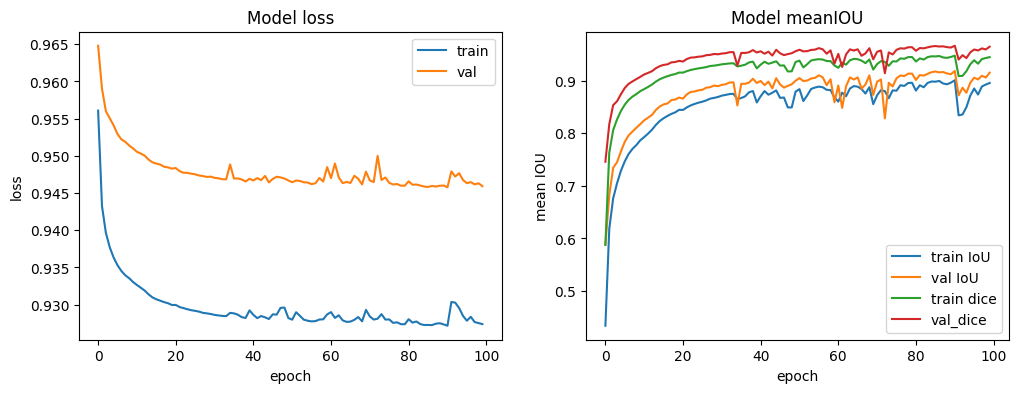

In [14]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(H['train_loss'])
plt.plot(H['test_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

plt.subplot(122)
plt.plot(H['train_IoU'])
plt.plot(H['test_IoU'])
plt.plot(H['train_DC'])
plt.plot(H['test_DC'])
plt.title('Model meanIOU')
plt.ylabel('mean IOU')
plt.xlabel('epoch')

plt.legend(['train IoU', 'val IoU', 'train dice', 'val_dice'], loc='lower right')

plt.show()

In [15]:
def make_prediction(model, image):
	image = torch.Tensor(image).permute((2, 0, 1)).to(DEVICE)
	image = torch.unsqueeze(image, 0)
	# set model to evaluation mode
	model.eval()
	# turn off gradient tracking
	with torch.no_grad():
		predMask = model(image)
		predMask = softmax(predMask)
		predMask = torch.squeeze(predMask, 0)
		predMask = predMask.permute((1, 2, 0))
		predMask = predMask.cpu().detach().numpy()
		predMask = np.argmax(predMask, axis=-1)
		predMask = np.expand_dims(predMask, axis=-1)
		# filter out the weak predictions and convert them to integers
		return predMask.astype(np.uint8)


In [16]:
def getPredImg(image_path):     
    image = cv2.imread(image_path)
    image = image[10:-10, 10:-10,:]
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT))
    image = image / 255
    return image

def getPredMask(mask_path):
    mask = cv2.imread(mask_path)
    mask = mask[10:-10, 10:-10,:]
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.resize(mask, (INPUT_IMAGE_WIDTH, INPUT_IMAGE_HEIGHT), interpolation=cv2.INTER_NEAREST)
    mask = np.expand_dims(mask, axis=-1)
    mask = encode_mask(mask)
    return mask

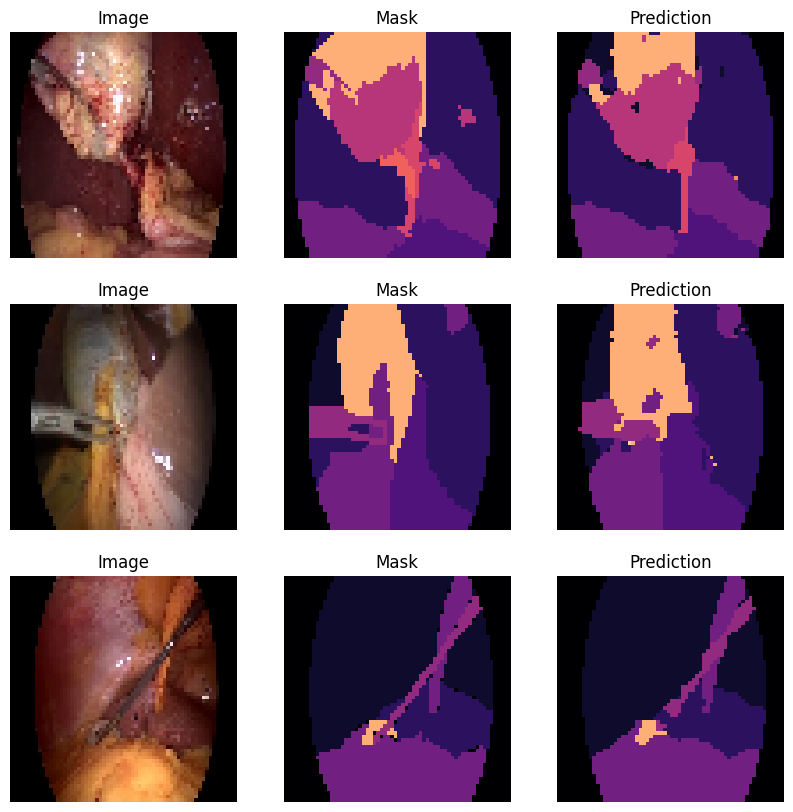

In [17]:
plt.figure(figsize=(10,10))
for i in range(3):    

    idx = random.randint(0, len(testImages) -1)
    img = getPredImg(testImages[idx])
    mask = getPredMask(testMasks[idx])
    
    plt.subplot(331 + 3*i)
    plt.imshow(img)
    plt.title('Image')
    plt.axis("off")

    mask = np.argmax(mask, axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    plt.subplot(332 + 3*i)
    plt.imshow(mask, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Mask')
    plt.axis("off")

    pred = make_prediction(uformer, img)
    plt.subplot(333 + 3*i)
    plt.imshow(pred, cmap='magma', norm=plt.Normalize(vmin=0, vmax=12))
    plt.title('Prediction')
    plt.axis("off")

plt.show()

 --- 
 TFG - Alejandro García Mota